# **Imports**

---



In [ ]:
!pip install pmdarima
!pip install --upgrade statsmodels

import statsmodels as sm
import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
from statsmodels.tsa import api as tsa
import statsmodels.api as sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [ ]:

#Reading data
df2022 = pd.read_csv('/content/alldata.csv', index_col='date',parse_dates=True)
df2022=pd.DataFrame(df2022)
df2022.index = pd.to_datetime(df2022.index, format='%d-%m-%Y').strftime('%m-%Y')

data=df2022
df=data


# **Exploratory Data Analysis (EDA)**

---



In [ ]:
df= data
# shape of the DataFrame
print(df.shape)

# column names
print(df.columns)

# types of the columns
print(df.dtypes)

(24, 2)
Index(['production', 'heures'], dtype='object')
production    float64
heures        float64
dtype: object


In [ ]:
df.describe()

,production,heures
count,24.000000,24.000000
mean,270799.958333,37999.249498
std,60043.098917,8912.552844
min,198028.000000,22178.357147
25%,235954.500000,33121.106295
50%,266156.500000,36528.947278
75%,283301.500000,44344.889315
max,465688.000000,55498.456216


<Figure size 1700x600 with 0 Axes>

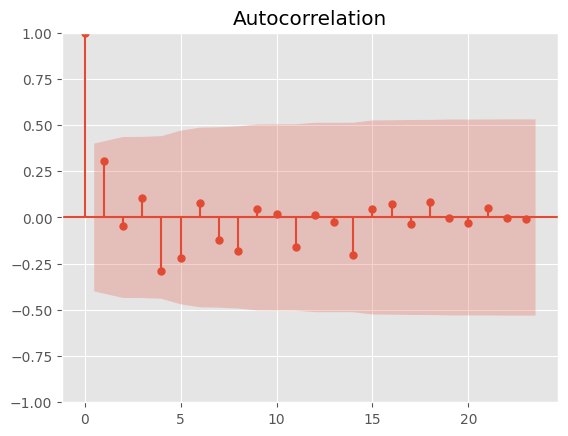

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(17, 6))
sm.graphics.tsa.plot_acf(df['production'], lags=23)
plt.show()

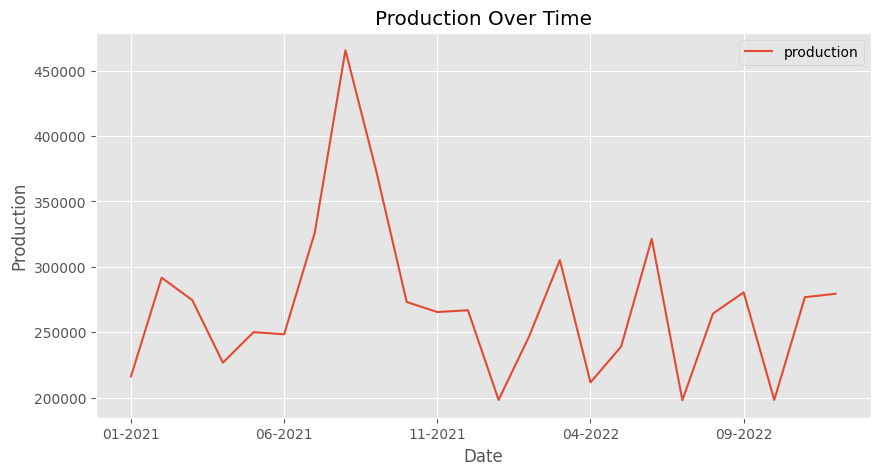

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.plot(y=['production'], figsize=(10, 5))
plt.title('Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()

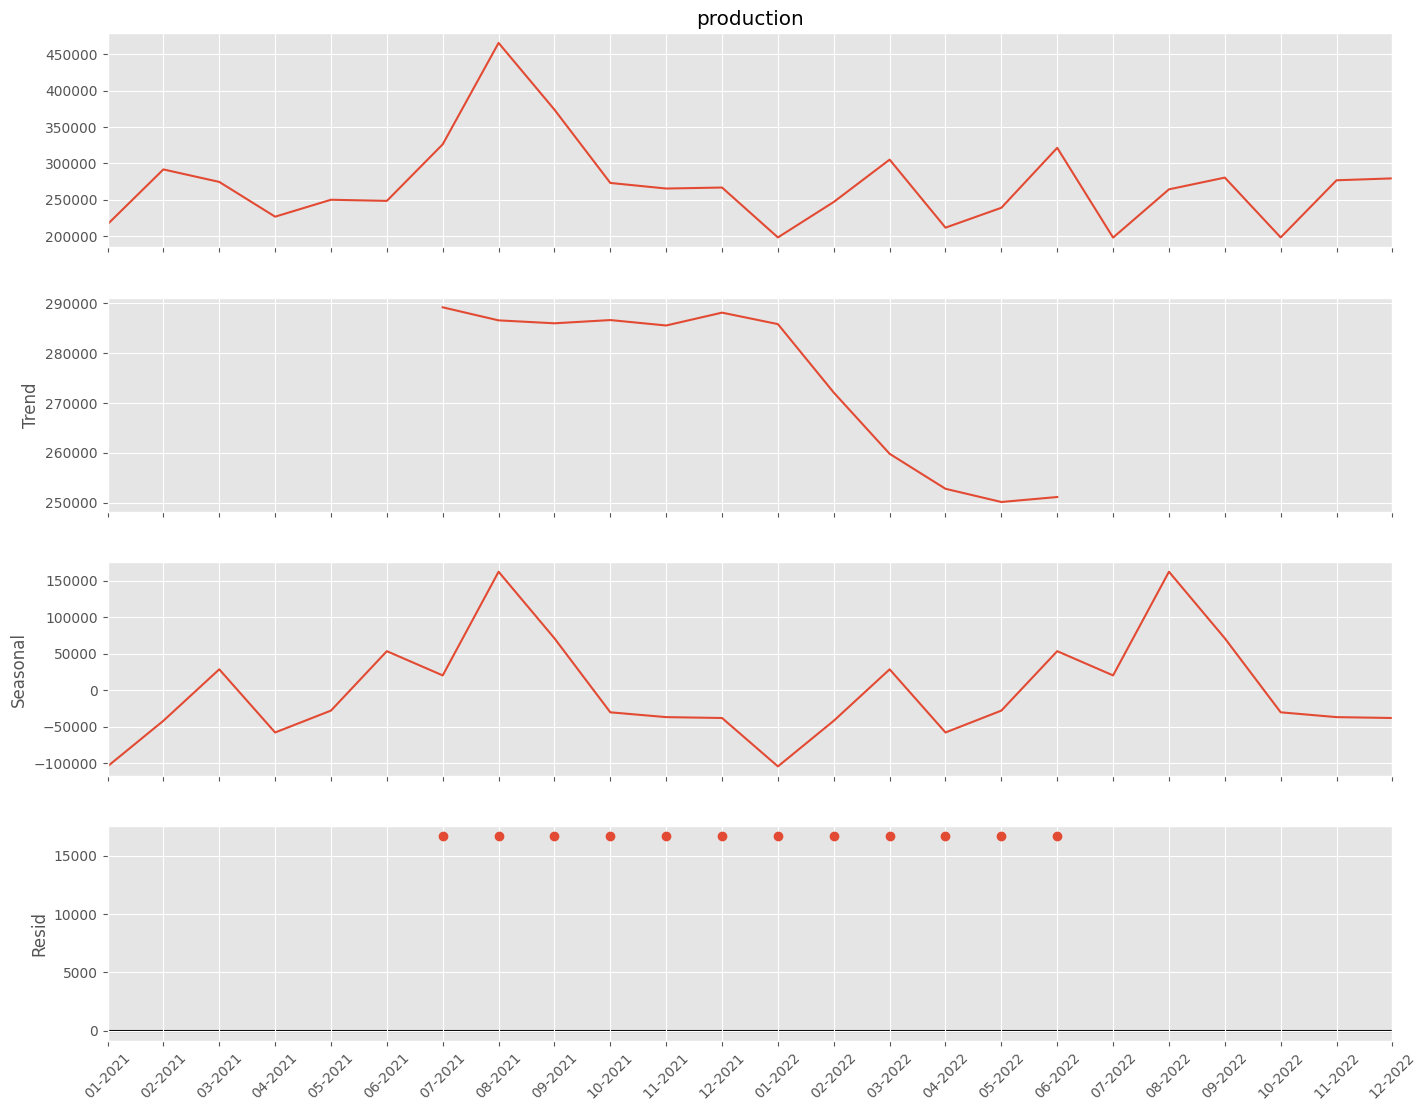

In [ ]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('ggplot')
decomposition = seasonal_decompose(df['production'], period=12)
fig = decomposition.plot()
plt.xticks(rotation = 45)
fig.set_size_inches(17, 12)

plt.xticks(rotation=45)
plt.show()

In [ ]:
def TestStationaryPlot(data):
    rol_mean = data.rolling(window =2, center = False).mean()
    rol_std = data.rolling(window =2, center = False).std()
    plt.style.use('ggplot')
    plt.plot(data, color = 'green',label = 'Original Data')
    plt.plot(rol_mean, color = 'purple', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10,rotation = 45)
    plt.xlabel('Time in Years', fontsize = 11)
    plt.ylabel('Quantity of production', fontsize = 25)
    plt.legend( fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)

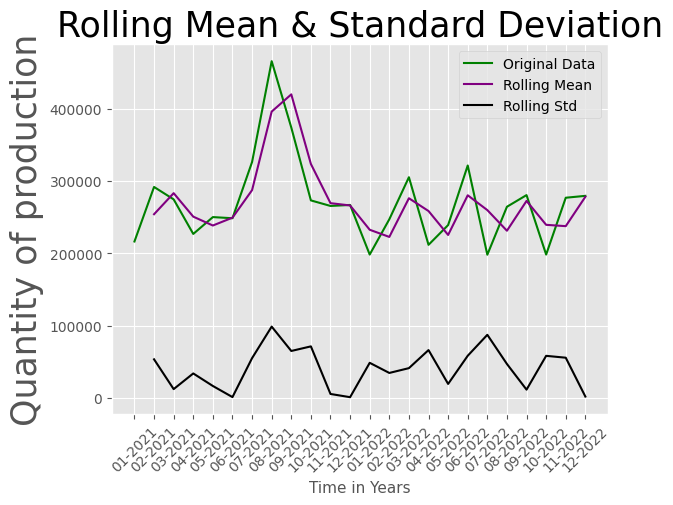

In [ ]:
TestStationaryPlot(data['production'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
TestStationaryAdfuller(data['production'], cutoff = 0.01)

Test Statistic                 -1.354478
p-value                         0.603895
#Lags Used                      6.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# **ARIMA Model preparation, training, testing and forecasting**

---



In [ ]:
# Load data
df = pd.read_csv('alldata.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'
df
df.index = pd.to_datetime(df.index, format='%Y-%m-%d').strftime('%m-%Y')
print(df)

         production        heures
date                             
01-2021    216310.0  22178.357147
02-2021    291745.0  33066.626753
03-2021    274574.0  33857.800000
04-2021    226764.0  24063.201039
05-2021    250057.0  26869.476321
06-2021    248478.0  30886.092116
07-2021    326258.0  43150.928600
08-2021    465688.0  55498.456216
09-2021    373915.0  53780.975244
10-2021    273151.0  45653.908352
11-2021    265468.0  43908.549636
12-2021    266845.0  41113.957149
01-2022    198234.0  34407.297031
02-2022    247023.0  36622.894557
03-2022    305206.0  46447.308434
04-2022    211683.0  26764.179952
05-2022    239018.0  33139.266142
06-2022    321419.0  48388.214460
07-2022    198028.0  34217.263086
08-2022    264354.0  47401.999701
09-2022    280487.0  42363.936016
10-2022    198234.0  34407.300000
11-2022    276829.0  36435.000000
12-2022    279431.0  37359.000000


In [ ]:
# Reading the data
df = pd.read_csv('alldata.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Getting the most order automatically using auto_arima
model = auto_arima(train_data['production'], seasonal=False, suppress_warnings=True)
order = model.order

print("The best order is:", order)

The best order is: (0, 0, 1)


In [ ]:
# train ARIMA model on training data
model = ARIMA(train_data['production'], exog=train_data['heures'], order=(0, 0, 1))
fitted_model = model.fit()

# test data forecast
forecast = fitted_model.forecast(steps=5, exog=test_data['heures'])



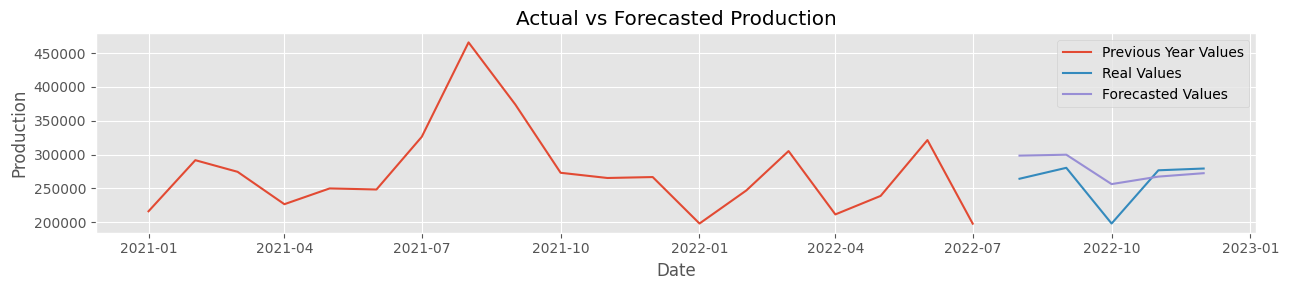

In [ ]:

# comparison plot for training
fig, axs = plt.subplots(figsize=(13, 3))
axs.plot(train_data['production'], label='Previous Year Values')
axs.plot(test_data['production'], label='Real Values')
axs.plot(forecast, label='Forecasted Values')
axs.set_title('Actual vs Forecasted Production')
axs.set_xlabel('Date')
axs.set_ylabel('Production')
axs.legend()
plt.tight_layout()
plt.show()

In [ ]:
# RMSE
mse = mean_squared_error(test_data['production'], forecast)
rmse_arima = np.sqrt(mse)
table_data = {'RMSE': [rmse_arima]}
table = pd.DataFrame(table_data, index=['Production'])
print(table)

                    RMSE
Production  31826.324043


In [ ]:
df2023 = pd.DataFrame({'production':[]})


df2023.loc['01-2023'] = {'production': 215313.0}
df2023.loc['02-2023'] = {'production': 220311.0}
df2023.loc['03-2023'] = {'production': 242173.0}
df2023.index=pd.to_datetime(df2023.index, format='%m-%Y').strftime('%m-%Y')
df2023

,production
01-2023,215313.0
02-2023,220311.0
03-2023,242173.0


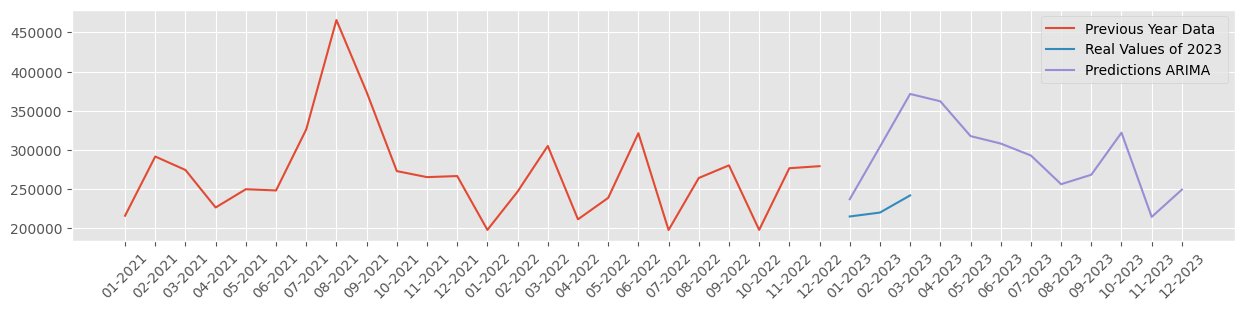

In [ ]:
import numpy as np
tz = 'UTC'
test_data.index = pd.to_datetime(test_data.index, utc=True)

# Periods to forecast
n_periods = 12
#creating the date range for for next year pred based on the test data index
next_year = pd.date_range(start=test_data.index[-1], periods=n_periods+1, freq='M', tz=tz)[1:]

#changing it to date format mm yyyy
next_year = next_year.tz_convert(None).strftime('%m-%Y')

# 2d reshapee for the hours
exog_reshaped = np.array(df['heures']).reshape(-1, 1)[:17]

#doing the prediction with the new year data range
next_year_predictions_arima = fitted_model.predict(start=next_year[0], end=next_year[-1], exog=exog_reshaped)

#formating the prediction dataframe index to mm yyyy
next_year_predictions_arima.index = next_year_predictions_arima.index.strftime('%m-%Y')
df.index = pd.to_datetime(df.index, format='%m-%Y').strftime('%m-%Y')

#plotting prediction
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 3))
plt.xticks(rotation=45)
ax.plot(df['production'], label='Previous Year Data')
ax.plot(df2023.index, df2023['production'],label ='Real Values of 2023')
ax.plot(next_year_predictions_arima, label='Predictions ARIMA')
plt.legend()
plt.show()


# **SARIMA Model preparation, training, testing and prediction**




In [ ]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

t=df['production']
# finding the best order for sarima model using "auto_arima" function
model = auto_arima(t, seasonal=True, start_p=0, d=1, start_q=0 ,
                   max_p=5, max_q=5, start_P=0,D=1,start_Q=0 ,max_D=5, max_Q=5,
                   m=12,max_order=None, suppress_warnings=True, stepwise=True,random_state=10,
                   n_fits=50)
print("Best order is : ",model.order, model.seasonal_order)

Best order is :  (0, 1, 0) (1, 1, 0, 12)


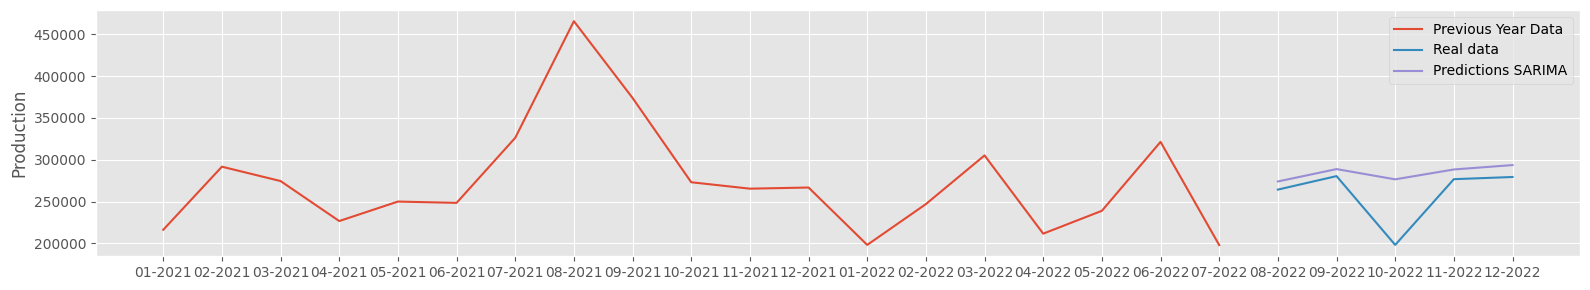

In [ ]:

tz = 'UTC'
test.index = pd.to_datet
P=4ime(test.index, utc=True)
train.index = pd.to_datetime(train.index, utc=True)
test.index = test.index.tz_convert(None).strftime('%m-%Y')
train.index = train.index.tz_convert(None).strftime('%m-%Y')
d=1
D=1
# SARIMA
import warnings
warnings.filterwarnings("ignore")
sarima_model = SARIMAX(t, order=(model.order[0], d, model.order[1]),
                       seasonal_order=(model.seasonal_order[0], D, model.seasonal_order[1], P),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()
predictions = sarima_results.forecast(steps=len(test),freq='M', tz=tz)
# prediction plots
plt.style.use('ggplot')
fig, axs = plt.subplots( figsize=(16,3))
axs.plot(train['production'], label='Previous Year Data')
axs.plot(test['production'], label='Real data')
axs.plot(test.index, predictions, label='Predictions SARIMA')
axs.set_ylabel('Production')
axs.legend()
plt.tight_layout()
plt.show()




In [ ]:
# RMSE
rmse_sarima = np.sqrt(mean_squared_error(test['production'], predictions))
print(f"RMSE: {rmse_sarima:.2f}")


RMSE: 36458.67


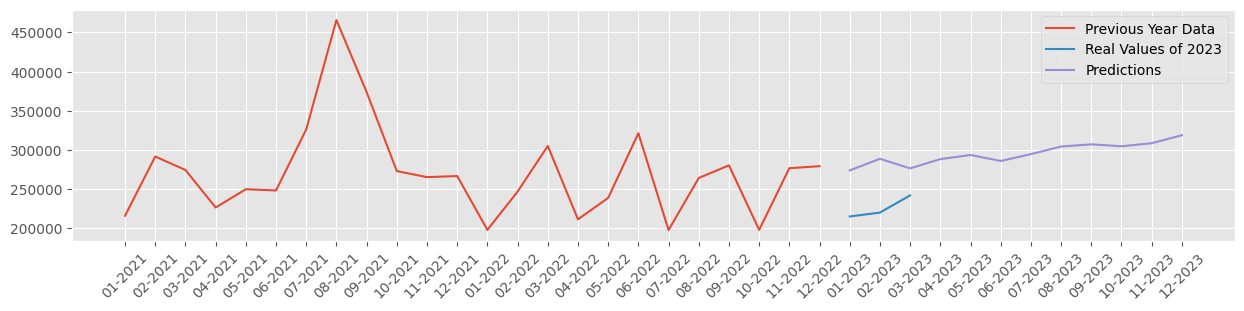

In [ ]:
tz = 'UTC'
test.index = pd.to_datetime(test.index, utc=True)

# Periods to forecast
n_periods = 12

# Indexing
next_year = pd.date_range(start=test.index[-1], periods=n_periods+1, freq='M', tz=tz)[1:]
next_year = next_year.tz_convert(None).strftime('%m-%Y')
next_year_predictions_sarima = sarima_results.predict(start=next_year[0], end=next_year[-1])

# Plot data and predictions
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 3))
plt.xticks(rotation=45)
ax.plot(df['production'], label='Previous Year Data')
ax.plot(df2023.index, df2023['production'],label ='Real Values of 2023')
ax.plot(next_year,next_year_predictions_sarima, label='Predictions')
plt.legend()
plt.show()


# **XGBoost Model preparation, training, testing and prediction**

---



In [ ]:

data = df['production']
#data preparation XGBoost model
months = [int(date.split('-')[0]) for date in data.index]
years = [int(date.split('-')[1]) for date in data.index]

dd=pd.DataFrame({'production':data,'month':months,'year':years})
dd.index=data.index
data=pd.DataFrame(data)
data = dd
print(data)
# Split the data into training and testing sets
train_size = 20
# Split the data into training and testing sets
train_data = data[['month','year']].iloc[:train_size]
test_data =data[['month','year']].iloc[20:]
train_labels = data['production'].iloc[:train_size]
test_labels = data['production'].iloc[20:]
print(test_data)


         production  month  year
date                            
01-2021    216310.0      1  2021
02-2021    291745.0      2  2021
03-2021    274574.0      3  2021
04-2021    226764.0      4  2021
05-2021    250057.0      5  2021
06-2021    248478.0      6  2021
07-2021    326258.0      7  2021
08-2021    465688.0      8  2021
09-2021    373915.0      9  2021
10-2021    273151.0     10  2021
11-2021    265468.0     11  2021
12-2021    266845.0     12  2021
01-2022    198234.0      1  2022
02-2022    247023.0      2  2022
03-2022    305206.0      3  2022
04-2022    211683.0      4  2022
05-2022    239018.0      5  2022
06-2022    321419.0      6  2022
07-2022    198028.0      7  2022
08-2022    264354.0      8  2022
09-2022    280487.0      9  2022
10-2022    198234.0     10  2022
11-2022    276829.0     11  2022
12-2022    279431.0     12  2022
         month  year
date                
09-2022      9  2022
10-2022     10  2022
11-2022     11  2022
12-2022     12  2022


In [ ]:
# DMatrix object
dtrain = xgb.DMatrix(data=train_data, label=train_labels)
dtest = xgb.DMatrix(data=test_data)
# grid parameters
param_grid = {
    'max_depth': [2,3,5],
    'eta': [0.05, 0.01, 0.1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'min_child_weight': [1, 2, 5]
}
# XGBoost model
xgb_model = xgb.XGBRegressor()

# cross validation
tscv = TimeSeriesSplit(n_splits=3)

# grid search object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
# fitting the training data
grid_search.fit(train_data,train_labels)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'eta': [0.05, 0.01, 0.1], 'max_depth': [2, 3, 5],
                         'min_child_weight': [1, 2, 5],
                         'subsample': [0.5, 0.7, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# best param and rmse results
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)
print('Best params:', best_params)
print('Best RMSE:', best_rmse)

Best params: {'colsample_bytree': 0.5, 'eta': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5}
Best RMSE: 82509.65345745138


In [ ]:
# train XGBoost model
num_rounds = 100
xgb_model = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=num_rounds)

# predictions on test data
predictions = xgb_model.predict(dtest)

# RMSE
rmse_xgb = np.sqrt(np.mean((test_labels - predictions) ** 2))
print('RMSE:', rmse_xgb)

RMSE: 40977.04654067066


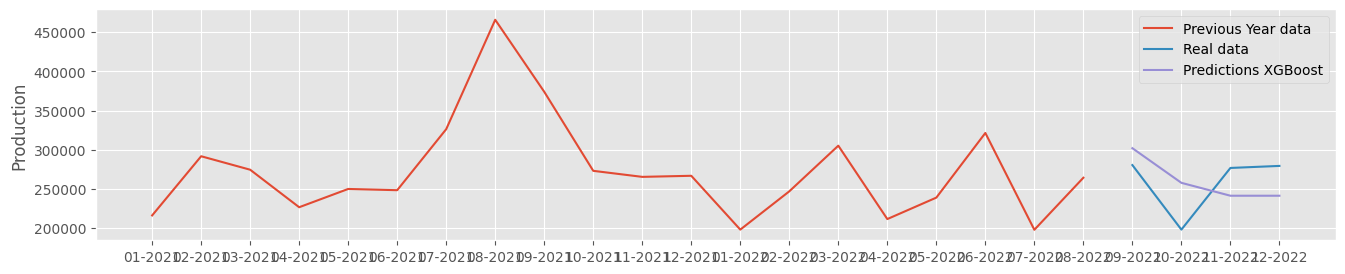

In [ ]:
#plot predictions of XGBoost
fig, axs = plt.subplots(figsize=(16, 3))
axs.plot(train_labels, label='Previous Year data')
axs.plot(test_labels, label='Real data')
axs.plot(test_data.index, predictions, label='Predictions XGBoost')
axs.set_ylabel('Production')

axs.legend()

In [ ]:

# setup next year data
next_year_data = pd.DataFrame(index=pd.date_range(start='01-2023', end='12-2023', freq='MS'))


next_year_data.index=next_year_data.index.strftime('%m-%Y')


months = [int(date.split('-')[0]) for date in next_year_data .index]
years = [int(date.split('-')[1]) for date in next_year_data .index]
next_year_data['month']=months
next_year_data['year']=years

print(next_year_data)


# next year data to dmatrix
next_year_data_dm = xgb.DMatrix(next_year_data)

# next year prediction
next_year_predictions_xgb = xgb_model.predict(next_year_data_dm)



         month  year
01-2023      1  2023
02-2023      2  2023
03-2023      3  2023
04-2023      4  2023
05-2023      5  2023
06-2023      6  2023
07-2023      7  2023
08-2023      8  2023
09-2023      9  2023
10-2023     10  2023
11-2023     11  2023
12-2023     12  2023


Next year predictions: [205325.8  246549.42 246754.3  229832.08 234905.14 252129.34 257575.23
 300942.94 302009.34 257859.6  241423.97 241423.97]


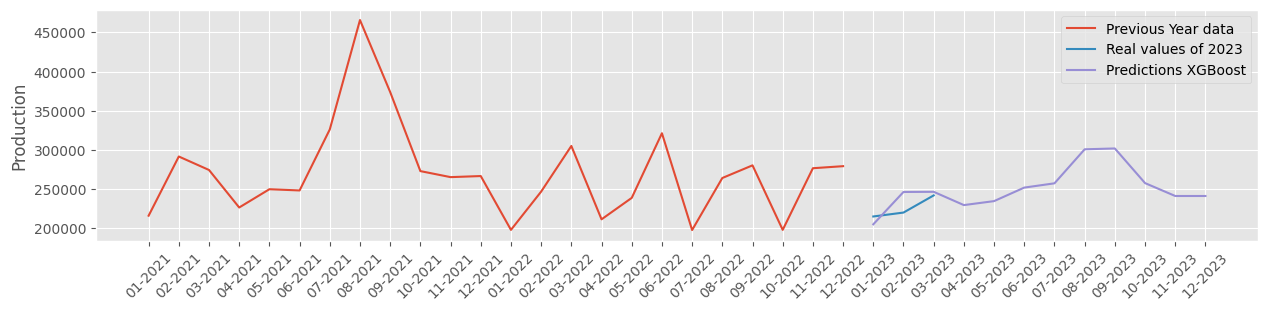

In [ ]:
#next year predictions
print("Next year predictions:", next_year_predictions_xgb)
plt.style.use('ggplot')
fig, axs = plt.subplots(figsize=(15, 3))
axs.plot(data['production'], label='Previous Year data')
axs.plot(df2023['production'],label ='Real values of 2023')
axs.plot(next_year_data.index, next_year_predictions_xgb, label='Predictions XGBoost')
axs.set_ylabel('Production')
plt.xticks(rotation=45)
axs.legend()
plt.show()

# **3 Models Comparison plot (ARIMA, SARIMA, XGBoost)**

---



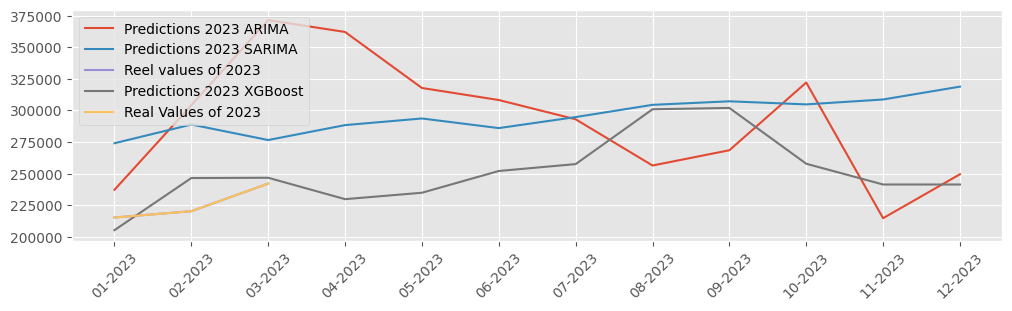

In [ ]:
# 3models comparison plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 3))
plt.xticks(rotation=45)
ax.plot(next_year_predictions_arima , label='Predictions 2023 ARIMA')
ax.plot(next_year,next_year_predictions_sarima, label='Predictions 2023 SARIMA')
ax.plot(df2023['production'],label ='Reel values of 2023')
ax.plot(next_year_predictions_xgb, label='Predictions 2023 XGBoost')
ax.plot(df2023.index, df2023['production'],label ='Real Values of 2023')
plt.legend()
plt.show()

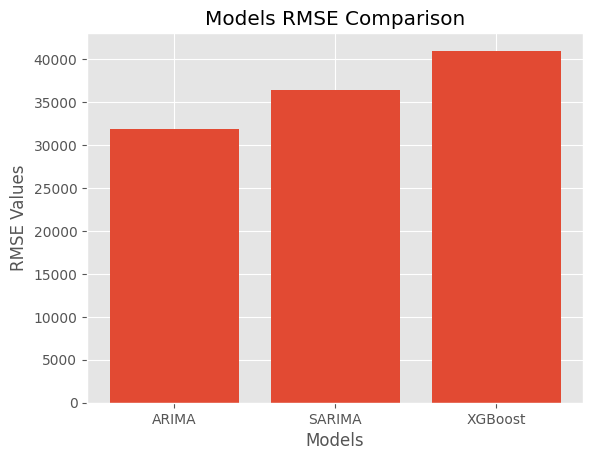

,Model,RMSE
0,ARIMA,31826.324043
1,SARIMA,36458.668903
2,XGBoost,40977.046541


In [ ]:
import matplotlib.pyplot as plt

# sample plot
x = ['ARIMA', 'SARIMA', 'XGBoost']
y = [rmse_arima, rmse_sarima, rmse_xgb]

comp= pd.DataFrame({'Model':x,'RMSE':y})

# bar plott
plt.bar(x, y)

# labels o title
plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('Models RMSE Comparison')

#  plot
plt.show()
comp